## **Import Libraries**

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import List
from pydantic import Field
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from IPython.display import Markdown
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from prompts import travel_agent_system_prompt, venue_agent_system_prompt, playlist_agent_system_prompt, coordinator_system_prompt
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.utilities import SQLDatabase
from tavily import TavilyClient
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.tools import tool
from dotenv import load_dotenv
import asyncio

# Load environment variables (API keys)
load_dotenv()

True

## **LLM Chat Model**

In [2]:
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

## **MCP Servers**

In [3]:
SERVER = {
        "travel_server": {
                "transport": "streamable_http",
                "url": "https://mcp.kiwi.com"
            }
        }

In [4]:
mcp_server = MultiServerMCPClient(SERVER)

## **Tools**

- **Travel Tools**

In [21]:
travel_tools = await mcp_server.get_tools()

{tool.name: tool for tool in travel_tools}.keys()

dict_keys(['search-flight', 'feedback-to-devs'])

In [22]:
["abc", *{tool.name: tool for tool in travel_tools}.keys()]

['abc', 'search-flight', 'feedback-to-devs']

- **Web Search Tool**

In [23]:
@tool
def web_search_tool(query: str) -> str:
    """Search the web for information."""
    tavily = TavilyClient()
    return tavily.search(query)

- **Database Tools (for retrieving playlist information)**

In [24]:
@tool
def query_playlist_db(query: str) -> str:
    """Query the database for playlist information."""
    try:
        db = SQLDatabase.from_uri("sqlite:///resources/Chinook.db")
        return db.run(query)
    except Exception as e:
        return str(e)

## **Agents**

- **Travel Agent**

In [ ]:
async def search_flight_agent():

    """
    Creates and returns a compiled LangGraph sub-graph for the Travel Agent.
    This agent specializes in finding flights using Kiwi.com MCP tools.
    """

    class TravelAgentState(TypedDict):
        messages: Annotated[List[BaseMessage], add_messages]
        flight_results: Optional[str]
    
    mcp_server = MultiServerMCPClient(SERVER)
    travel_tools = await mcp_server.get_tools()
    
    named_tools = {tool.name: tool for tool in travel_tools}
    print("Available flight tools:", list(named_tools.keys()))

    
    async def travel_agent_node(state: TravelAgentState) -> TravelAgentState:
        
        """
        Core agent node: sends system prompt + history to LLM with bound tools.
        LLM decides whether to call tools or give final answer.
        """

        system_message = SystemMessage(content=travel_agent_system_prompt)
        messages = [system_message] + state["messages"]

        llm_with_tools = llm.bind_tools(travel_tools)
        response = await llm_with_tools.ainvoke(messages)
        return { "messages": [response] }

    # ================================== Sub Graph ==============================================

    travel_agent = StateGraph(TravelAgentState)

    travel_agent.add_node("travel_agent_node", travel_agent_node)
    travel_agent.add_node("tools", ToolNode(travel_tools))

    travel_agent.add_edge(START, "travel_agent_node")
    travel_agent.add_conditional_edges("travel_agent_node", tools_condition)
    travel_agent.add_edge("tools", "travel_agent_node")

    return travel_agent.compile()

async def agent_flight_main(query: str) -> str:
    """Entry point to run the travel sub-graph with a user query."""
    flight_chatbot = await search_flight_agent()
    
    result = await flight_chatbot.ainvoke(
        {"messages": [HumanMessage(content=query)]},
    )
    return result


Available flight tools: ['search-flight', 'feedback-to-devs']


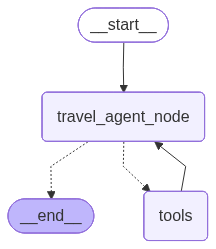

In [150]:
flight_chatbot = await search_flight_agent()
flight_chatbot

In [ ]:
flight_chatbot = await search_flight_agent()
    
result = await flight_chatbot.ainvoke(
    {"messages": [HumanMessage(content="Search a flight from Karachi to New York on June 10th, return June 20th")]},
)

Available tools: ['search-flight', 'feedback-to-devs']


In [102]:
print(result['messages'][-1].content)

Here are the best one-way outbound options from Karachi (KHI) to New York (JFK or EWR) on June 10, 2026. I’ve focused on the lowest price first, and also included the shortest duration option.

1) Cheapest option
- Route: KHI → JFK via IST (SAW) → ROM (FCO)
- Outbound times: 10/06 04:25 → 10/06 22:30 (duration: 27h 5m)
- Cabin: Economy
- Price: 1,056 EUR
- Deep link: https://on.kiwi.com/zaYWGp

2) Second cheapest
- Route: KHI → JFK via IST (SAW) → ROM (FCO)
- Outbound times: 10/06 04:25 → 10/06 22:30 (duration: 27h 5m)
- Cabin: Economy
- Price: 1,089 EUR
- Deep link: https://on.kiwi.com/xu18HA

3) Another good option to NYC (different NYC airport)
- Route: KHI → EWR via IST (IST) → ROM (ROM)
- Outbound times: 10/06 04:25 → 10/06 21:00 (duration: 25h 35m)
- Cabin: Economy
- Price: 1,097 EUR
- Deep link: https://on.kiwi.com/R2kuKU

4) Shortest outbound duration (still via multiple stops)
- Route: KHI → JFK via DOH → AMM
- Outbound times: 10/06 04:05 → 10/06 21:55 (duration: 17h 50m)
- Ca

- **Venue agent**

In [ ]:
async def venue_search_agent():

    """
    Creates and returns a compiled LangGraph sub-graph for the Venue Agent.
    Uses Tavily web search to find wedding venues.
    """

    class VenueAgentState(TypedDict):
        messages: Annotated[List[BaseMessage], add_messages]
        venue_results: Optional[str]
        steps: int
    
    venue_tools = [web_search_tool]
    print("Available venue tools:", [tool.name for tool in venue_tools])
    
    async def venue_agent_node(state: VenueAgentState) -> VenueAgentState:
        
        """
        Prevents infinite loops by tracking steps (optional guard).
        Binds web search tool and lets LLM research venues.
        """
        
        if state["steps"] >= 1:
            return state

        system_message = SystemMessage(content=venue_agent_system_prompt)
        messages = [system_message] + state["messages"]

        llm_with_tools = llm.bind_tools(venue_tools)
        response = await llm_with_tools.ainvoke(messages)
        return { "messages": [response], "steps": state["steps"] + 1 }

    # ================================== Sub Graph ==============================================
    venue_agent = StateGraph(VenueAgentState)

    venue_agent.add_node("venue_agent_node", venue_agent_node)
    venue_agent.add_node("tools", ToolNode(venue_tools))

    venue_agent.add_edge(START, "venue_agent_node")
    venue_agent.add_conditional_edges("venue_agent_node", tools_condition)
    venue_agent.add_edge("tools", "venue_agent_node")

    return venue_agent.compile()

async def agent_venue_main(query: str) -> str:
    
    """Entry point to run the venue sub-graph."""
    venue_chatbot = await venue_search_agent()
    
    result = await venue_chatbot.ainvoke(
        {"messages": [HumanMessage(content=query)], "steps": 0},
    )
    return result

Available venue tools: ['web_search_tool']


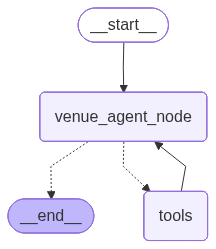

In [152]:
venue_chatbot = await venue_search_agent()
venue_chatbot

In [ ]:
venue_chatbot = await venue_search_agent()
    
result = await venue_chatbot.ainvoke(
    {"messages": [HumanMessage(content="Find wedding venues in New York for 100 guests")], "steps": 0},
)

In [118]:
print(result['messages'][-1].content)

{"query": "New York City wedding venue capacity 100 guests", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.tagvenue.com/us/hire/large-wedding-venues/new-york-city", "title": "Large Wedding Venues for Rent in New York City, NY - Tagvenue", "content": "100 guests. Carroll Hall. (8). Bushwick, New York City, NY. Hall. Private space ... The event venue has a capacity to accommodate 1350 guests in one sitting.", "score": 0.99996877, "raw_content": null}, {"url": "https://www.thepierrecentralparkweddings.com/venues", "title": "Wedding Venues NYC - The Pierre Weddings", "content": "Rotunda. 1st Floor | Capacity: 50 seated, 100 standing. What better place to ... in one of New York's most distinguished wedding venues? Between the", "score": 0.9999379, "raw_content": null}, {"url": "https://www.eventective.com/new-york-ny/wedding-venues/", "title": "Wedding Venues in New York, NY - 600 Venues | Pricing - Eventective", "content": "New York, NY (Turtle

- **Playlist agent**

In [ ]:
async def suggest_playlist_agent():

    """
    Creates and returns a compiled LangGraph sub-graph for the Playlist Agent.
    Queries Chinook database for music recommendations.
    """

    class PlaylistAgentState(TypedDict):
        messages: Annotated[List[BaseMessage], add_messages]
        venue_results: Optional[str]
    
    playlist_tools = [query_playlist_db]
    print("Available playlist tools:", [tool.name for tool in playlist_tools])
    
    async def playlist_agent_node(state: PlaylistAgentState) -> PlaylistAgentState:
        
        """Binds playlist tools and lets LLM research venues."""

        system_message = SystemMessage(content=playlist_agent_system_prompt)
        messages = [system_message] + state["messages"]

        llm_with_tools = llm.bind_tools(playlist_tools)
        response = await llm_with_tools.ainvoke(messages)
        return { "messages": [response]}

    # ================================== Sub Graph ==============================================
    venue_agent = StateGraph(PlaylistAgentState)

    venue_agent.add_node("playlist_agent_node", playlist_agent_node)
    venue_agent.add_node("tools", ToolNode(playlist_tools))

    venue_agent.add_edge(START, "playlist_agent_node")
    venue_agent.add_conditional_edges("playlist_agent_node", tools_condition)
    venue_agent.add_edge("tools", "playlist_agent_node")

    return venue_agent.compile()

async def agent_playlist_main(query: str) -> str:
    """Entry point to run the playlist sub-graph."""
    
    playlist_chatbot = await suggest_playlist_agent()
    
    result = await playlist_chatbot.ainvoke(
        {"messages": [HumanMessage(content=query)]},
    )
    return result

Available playlist tools: ['query_playlist_db']


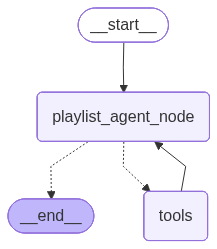

In [154]:
playlist_chatbot = await suggest_playlist_agent()
playlist_chatbot

In [122]:
result = await playlist_chatbot.ainvoke(
    {"messages": [HumanMessage(content="Find jazz-genre tracks for wedding playlist")]},
)

In [123]:
print(result['messages'][-1].content)

Here’s a curated Jazz wedding playlist pulled from the Jazz tracks that are wedding-appropriate. I’ve grouped them to give a smooth, romantic start with Jobim, a cool Miles segment, then upbeat swing with Gene Krupa, finishing with a well-rounded 55–60 minute set.

Recommended track order (20 tracks)
1) Outra Vez — Antônio Carlos Jobim — 2:07 — $0.99
2) Fotografia — Antônio Carlos Jobim — 2:09 — $0.99
3) Samba De Uma Nota Só (One Note Samba) — Antônio Carlos Jobim — 2:17 — $0.99
4) Desafinado — Antônio Carlos Jobim — 3:03 — $0.99
5) Por Causa De Você — Antônio Carlos Jobim — 2:50 — $0.99
6) Angela — Antônio Carlos Jobim — 2:50 — $0.99
7) Se Todos Fossem Iguais A Você (Instrumental) — Antônio Carlos Jobim — 2:15 — $0.99
8) Lament — Miles Davis — 2:14 — $0.99
9) The Meaning Of The Blues — Miles Davis — 2:49 — $0.99
10) Generique — Miles Davis — 2:50 — $0.99
11) I Don't Wanna Be Kissed (By Anyone But You) — Miles Davis — 3:11 — $0.99
12) Overtime — Gene Krupa — 2:43 — $0.99
13) Coronation

- **Main Coordinator Agent**

In [ ]:
async def main_coordinator_agent():

    """
    Creates the main coordinator graph that orchestrates all specialist agents.
    The coordinator uses LLM tool calling to dynamically invoke sub-graphs.
    """

    class WeddingState(TypedDict):
        messages: Annotated[List[BaseMessage], add_messages]
        origin: Optional[str]
        destination: Optional[str]
        guest_count: Optional[str]
        genre: Optional[str]
        flight_results: Optional[str]
        venue_results: Optional[str]
        playlist_results: Optional[str]

    # travel_app = await search_flight_agent()
    # venue_app = await venue_search_agent()
    # playlist_app = await suggest_playlist_agent()

    @tool
    async def travel_agent(state: WeddingState) -> WeddingState:
        """Travel agent searches for flights to the desired destination wedding location."""
        
        origin = state["origin"]
        destination = state["destination"]
        query = f"Find flights from {origin} to {destination}"
        
        response = await agent_flight_main(query)
        message = response['messages'][-1].content
        return { "messages": [message] }

    @tool
    async def venue_agent(state: WeddingState) -> WeddingState:
        """Venue agent chooses the best venue for the given location and capacity."""
        
        destination = state["destination"]
        capacity = state["guest_count"]
        query = f"Find wedding venues in {destination} for {capacity} guests"

        response = await agent_venue_main(query)
        message = response['messages'][-1].content
        return { "messages": [message] }

    @tool
    async def playlist_agent(state: WeddingState) -> WeddingState:
        """Playlist agent curates the perfect playlist for the given genre."""
        
        genre = state["genre"]
        query = f"Find {genre} tracks for wedding playlist"

        response = await agent_playlist_main(query)
        message = response['messages'][-1].content
        return { "messages": [message] }

    tools = [travel_agent, venue_agent, playlist_agent]
    print("Available agent tools:", [tool.name for tool in tools])

    async def main_agent_node(state: WeddingState) -> WeddingState:
        """Coordinator node: uses system prompt and tool calling."""
        
        llm_with_tools = llm.bind_tools(tools)
        messages = [coordinator_system_prompt] + state["messages"]
        response = await llm_with_tools.ainvoke(messages)

        return { "messages": [response] }

    # ================================== Sub Graph ==============================================
    main_agent = StateGraph(WeddingState)

    main_agent.add_node("main_agent_node", main_agent_node)
    main_agent.add_node("tools", ToolNode(tools))

    main_agent.add_edge(START, "main_agent_node")
    main_agent.add_conditional_edges("main_agent_node", tools_condition)
    main_agent.add_edge("tools", "main_agent_node")

    return main_agent.compile()

Available agent tools: ['travel_agent', 'venue_agent', 'playlist_agent']


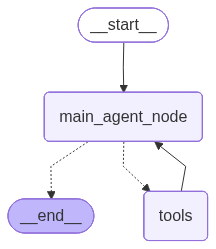

In [156]:
main_chatbot = await main_coordinator_agent()
main_chatbot

## **Test**

In [157]:
from langchain.messages import HumanMessage

response = await main_chatbot.ainvoke(
    {
        "messages": [HumanMessage(content="I'm from London and I'd like a wedding in Paris for 100 guests, jazz-genre playlist")],
        "origin": "Karachi",
        "destination": "New York",
        "guest_count": "100",
        "genre": "jazz",
    }
)

Available venue tools: ['web_search_tool']
Available playlist tools: ['query_playlist_db']
Available flight tools: ['search-flight', 'feedback-to-devs']
Available flight tools: ['search-flight', 'feedback-to-devs']


In [146]:
from pprint import pprint

pprint(response)

{'destination': 'New York',
 'genre': 'jazz',
 'guest_count': '100',
 'messages': [AIMessage(content='Fantastic. I’ll coordinate the three specialist tracks (flights, venues, playlists) and keep everything synced. To update the state and kick off parallel searches, I need a few details from you.\n\nPlan\n- Step 1: Gather all necessary inputs to populate the state (origin, destination, dates, guests, budgets, style, etc.).\n- Step 2: Assign tasks to specialists (Travel Agent, Venue Agent, Playlist Agent) and run in parallel.\n- Step 3: When responses come back, I’ll synthesize a coordinated plan and present you with options, trade-offs, and a recommended path.\n\nPlease provide answers to as many of these as you can. If something isn’t fixed yet, I’ll note it as flexible.\n\nRequired information\n\n1) Flights (origin and travel details)\n- Origin city/airport for guests (main departure point):\n- Destination/wedding location city and country:\n- Wedding date (or a date window) and any f

In [158]:
Markdown(response['messages'][-1].content)

Wonderful. I’ve gathered and organized the core information we need to plan your Paris wedding for 100 guests with a jazz-focused playlist. Here’s the current state and what I’ll delegate next to my specialists to move us forward.

Current state update
- You: from London
- Destination: Paris
- Guests: 100
- Music vibe: Jazz (playlist provided)
- Flights (top options found):
  - SEN → CDG: 02 Jul 2026, 13:45–15:55, ~1h10m, Economy, 32 EUR
  - LTN → CDG: 01 Jun 2026, 19:40–22:00, ~1h20m, Economy, 53 EUR
  - LTN → CDG: 02 Jun 2026, 19:10–21:30, ~1h20m, Economy, 53 EUR
  - LGW → CDG: 04 Jun 2026, 17:00–19:20, ~1h20m, Economy, 56 EUR
  - Notes: Late spring to early summer 2026 is ideal; from LON area airports often best value; from LGW if you want a major hub.
- Venue landscape (Paris, for 100 guests):
  - Typical ranges:
    - Mid-range venue hire: 15,000–30,000 EUR (plus catering 10,000–30,000 EUR)
    - Luxury venues: 30,000–100,000+ EUR
    - Rooftop venues: 10,000–20,000 EUR (venue hire)
    - Entertainment: DJ 1,500–3,000 EUR; Live band 2,500–8,000 EUR
    - Full-service planning: 3,000–10,000 EUR; Day-of coordination: 1,000–3,000 EUR
  - Lead times: 6–12+ months; June is popular and benefits from early booking
  - Notes: Availability in June is favorable but still requires early action; venues range from châteaux and luxury hotels to rooftop terraces.
- Playlist (Jazz, 20 tracks):
  - Total duration: ~84 minutes 27 seconds
  - Total cost: $19.80
  - Included tracks are mostly Brazilian jazz (bossa nova) and jazz fusion elements, plus some classic standards as mood-setters
  - Suggested flow (optional rearrangement available): Romantic start through dinner, with a gentle build into later tracks
  - Next step: I can export as CSV/CSV-to-M3U or tailor the order for specific moments (arrival, dinner, dancing)

What I’ll delegate to my specialists (next steps)
1) Flights/Logistics Specialist
- Objective: Lock in 2–3 flight options for your group that balance price, timing, and convenience.
- Deliverables:
  - A shortlist of 2–3 group-friendly options from the most convenient London airports (SEN, LTN, LGW, any others you prefer) to CDG.
  - Clear travel day ranges for you and any helpers (e.g., arrival 1 day before, group transfer timing, return plan).
  - Practical notes on baggage, group seating, and any potential changes if dates shift.
- What I need from you: preferred arrival/departure airports, your target wedding date window in Paris, and any airport or timing constraints.

2) Venue Coordinator
- Objective: Curate 3–5 Paris venues suited to 100 guests with a jazz-friendly vibe, showing realistic price ranges and availability for June.
- Deliverables:
  - Shortlist with 3–5 venue types (e.g., luxury hotel ballroom with a terrace, rooftop Paris venue, château-style venue outside the city, boutique venue in central Paris) and 1–2 concrete example venues per type (with non-binding quotes or ranges).
  - Estimated totals for venue hire + catering + entertainment, and notes on capacity, acoustics, and dance-floor space for live jazz or a DJ.
  - Availability outlook for June 2026 and recommended booking timeline (including hold-and-release options if needed).
- What I need from you: preferred venue style (luxury hotel, château, rooftop, intimate boutique), dietary/hosting needs (vegetarian/vegan options, kosher/Halal, etc.), and whether you want symbolic ceremony in Paris or only reception.

3) Playlist/Entertainment Specialist
- Objective: Finalize a wedding-friendly jazz playlist that suits each moment of the day and aligns with licensing and soundscape.
- Deliverables:
  - Two refined mood options (e.g., A) Romantic Jazz & Bossa Nova flow; B) Classic Jazz Standards with light swing) and a final recommended order for key moments: guest arrival, cocktail, dinner, dance floor, send-off.
  - A ready-to-use file (CSV or M3U) and a brief license-check reminder (permissions for public performance; I can coordinate with a DJ or live band if you choose that route).
  - Optional: a “Live music + DJ hybrid” plan with approximate timing and setup notes.
- What I need from you: preferred mood focus (romantic, danceable, a mix), whether you want only pre-recorded tracks or live jazz/bossa nova, and any must-have songs or artists to include/exclude.

A few quick questions to align before I delegate
- What is your target wedding date or date window in Paris (month/week)?
- Do you prefer a specific London airport or multiple departure points for guests?
- Do you want a symbolic ceremony in Paris or only a reception, and where in the day should music be strongest (cocktail hour, dinner, dancing)?
- Any dietary requirements or menu style you’re leaning toward (formal plated dinner vs. buffet vs. canapés with stations)?
- Budget rough ranges for venue hire, catering, and entertainment (e.g., conservative, balanced, or lavish)?
- Do you want the playlist to lean more toward classic standards (Frank Sinatra, Ella, Nat King Cole) or strictly jazz/bossa nova selections as currently outlined?

Next, I can dispatch the three specialists to start gathering options and concrete proposals. Once I have their answers, I’ll coordinate the best combination of flight logistics, venue, and music to deliver a cohesive, elegant Paris wedding for 100 with a standout jazz soundtrack.

If you’re ready, tell me:
- Your target date window
- Airport/transport preferences
- Any must-have or must-avoid items (venues, songs, or travel constraints)

I’ll proceed to task the specialists right away and bring back a tight, option-rich plan.